In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
from numpy import linalg as LA
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import paired_distances

PATH_YANGNET = '/Users/lauradriscoll/Documents/code/yangnet/training' #'/home/laura/code/yangnet/training'
sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools

from tools_lnd import gen_trials_from_model_dir, gen_X_from_model_dir, gen_X_from_model_dir_epoch, name_best_ckpt, find_ckpts, get_model_params

In [17]:
def plot_sitch(fpf_dict,stim,trial_set,pc_ind0=0,pc_ind1=1):
    qmap=plt.get_cmap('hot')
    cmap=plt.get_cmap('rainbow')
    
    pca = PCA()
    # pca on only task 0
    X = fpf_dict[rule_set[0]]['state_traj'][trial_set,:,:] 
    # pca on traj for both tasks
#     X = np.concatenate((fpf_dict[rule_set[0]]['state_traj'][trial_set,:,:], 
#                         fpf_dict[rule_set[1]]['state_traj'][trial_set,:,:]),axis = 0)
    X_pca = pca.fit_transform(X.reshape((np.shape(X)[0]*np.shape(X)[1], np.shape(X)[2])))

    for xi in range(len(fpf_dict[rule]['xstar'])):
        c_go = qmap(fpf_dict[rule]['qstar'][xi]/np.max(fpf_dict[rule_set[0]]['qstar']))
        c_anti = qmap(fpf_dict[rule]['qstar'][xi]/np.max(fpf_dict[rule_set[1]]['qstar']))
                      
        xstar_pca = pca.transform(np.expand_dims(fpf_dict[rule_set[0]]['xstar'][xi],axis = 1))
        plt.plot(xstar_pca[:,pc_ind0],xstar_pca[:,pc_ind1],'o', color = c_go,alpha = .01)

        xstar_pca = pca.transform(np.expand_dims(fpf_dict[rule_set[1]]['xstar'][xi],axis = 1))
        plt.plot(xstar_pca[:,pc_ind0],xstar_pca[:,pc_ind1],'x', color = c_anti,alpha = .01)

    for t in trial_set:
        print(t)
        c = cmap(t/np.shape(fpf_dict[rule_set[0]]['state_traj'])[1])
        
        X_trial = pca.transform(fpf_dict[rule_set[0]]['state_traj'][t,:,:])
        plt.plot(X_trial[stim,pc_ind0],X_trial[stim,pc_ind1],'o',c = c)
        plt.plot(X_trial[stim:T,pc_ind0],X_trial[stim:T,pc_ind1],'-',c = c)

        X_trial = pca.transform(fpf_dict[rule_set[1]]['state_traj'][t,:,:])
        plt.plot(X_trial[stim,pc_ind0],X_trial[stim,pc_ind1],'o',c = c)
        plt.plot(X_trial[stim:,pc_ind0],X_trial[stim:,pc_ind1],':',c = c)
        
def q_scale(q):
    q_shift = q - np.min(q)
    qs = q_shift/np.max(q_shift)
    return qs

In [19]:
trial = {}
fpf_dict = {}
rule_set = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']#['reactgo','reactanti']
model_n = 0

for rule in rule_set:
    filename = rule+'_go1.npy'
    dir_specific_all = 'grad_norm_l2h000001'
    model_dir = os.path.join('/Users/lauradriscoll/Documents/data/rnn/multitask/lowD/',dir_specific_all,'most',str(model_n))
    save_dir = os.path.join(model_dir,'fixed_pts',rule)
    
    fpf_dict[rule] = np.load(os.path.join(save_dir,filename)).item()
    trial[rule] = gen_trials_from_model_dir(model_dir,rule)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2h000001/most/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2h000001/most/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2h000001/most/0/model.ckpt

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2h000001/most/0/model.ckpt


In [20]:
xstar_all = fpf_dict[rule_set[0]]['xstar']
rule_label_all = np.zeros((np.shape(fpf_dict[rule_set[0]]['xstar'])[0],1))
for ri in range(1,len(rule_set)):
    xstar_all = np.concatenate((xstar_all, fpf_dict[rule_set[ri]]['xstar']),axis = 0)
    rule_label_all = np.concatenate((rule_label_all, ri*np.ones((np.shape(fpf_dict[rule_set[0]]['xstar'])[0],1))),axis = 0)
    
pca = PCA()
xstar_all_pca = pca.fit_transform(xstar_all)

In [21]:
from sklearn.manifold import MDS

X = xstar_all
row_means = np.mean(X, axis=0)
row_var = np.var(X, axis=0)
X_center = X - np.tile(row_means,(X.shape[0],1))
X_ball = np.true_divide(X - np.tile(row_means,(X.shape[0],1)), np.tile(row_var,(X.shape[0],1)))
xstar_all_dist = euclidean_distances(X_center)

embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(xstar_all_dist.astype(np.float64))

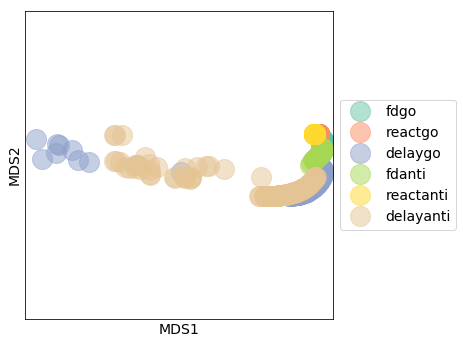

In [23]:
fig = plt.figure(figsize=(5, 5),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 14})
cmap=plt.get_cmap('Set2')

plot_rules = range(6)#[0, 1, 3, 4]
ax=fig.add_subplot(111)
for ri in range(len(plot_rules)):
    c = cmap(ri/len(plot_rules))
    inds = range(plot_rules[ri]*200,(plot_rules[ri]+1)*200)
    plt.plot(X_transformed[inds,0],X_transformed[inds,1],'.',MarkerSize = 40,color = c ,alpha=.5) #np.repeat(range(len(rule_set)), 200)
plt.legend([rule_set[j] for j in plot_rules],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim((1.3*np.min(X_transformed[:,0]),1.3*np.max(X_transformed[:,0])))
plt.ylim((1.3*np.min(X_transformed[:,1]),1.3*np.max(X_transformed[:,1])))
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.savefig('ncm/load_fps_compare/' + 'mds_fpts' + 
            dir_specific_all + '_model_' + str(model_n) + '.svg')
plt.show()